In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from pathlib import Path
from run_grid_search import plot_best, make_dataloaders, run_validation, plot_history, make_dataloaders_old, run_grid_search, train_model
from models import modular_network

import torch
from torch import nn
from gzip import BadGzipFile

device="cuda"

In [2]:
def plot_best(df, test_seq_path, embeddings_path, output_prefix, device):
    r = df.iloc[df['val_auc'].idxmax()]
    print(f"batch_size: {r['batch_size']}, drop_out: {r['drop_out']}, n_layers: {r['n_layers']}, epoch: {r['epoch']}")
    
    model = modular_network(r["n_layers"], r["drop_out"])
    model.load_state_dict(torch.load(r["model_name"], weights_only=True))
    model.eval()
    
    val_loader = make_dataloaders(input_path=test_seq_path, embeddings=embeddings_path, batch_size=int(r["batch_size"]))
    pred, labels = run_validation(model, val_loader, device=device)
    plot_auc(pred, labels, output_prefix)
    
    df_hist = pd.DataFrame(r.history)
    plot_history(df_hist, output_prefix)

def create_paths(prefix: Path):
    results_folder = Path(f"results/{prefix.stem}")
    results_file = results_folder / Path(f"{prefix.stem}_gridsearch_results.tsv")
    val_seq_path = Path(f"{prefix}_val.tsv" )
    embeddings_path = Path(f"{prefix}_embeddings.tsv")

    return results_folder, results_file, val_seq_path, embeddings_path

def run_best_model(df, val_seq_path, embeddings_path=None, input_size = 3840):
    r = df.iloc[df['val_auc'].idxmax()]
    print(f"Best Params:\nbatch_size: {r['batch_size']}, drop_out: {r['drop_out']}, n_layers: {r['n_layers']}, epoch: {r['epoch']}, AUC: {r['val_auc']}")
    model = modular_network(r["n_layers"], r["drop_out"], input_size=input_size)
    model.load_state_dict(torch.load(r["model_name"], weights_only=True))
    model.eval()
    if embeddings_path == None:
        val_loader = make_dataloaders_old(input_path=val_seq_path, batch_size=int(r["batch_size"]))
    else:
        val_loader = make_dataloaders(input_path=val_seq_path, embeddings=embeddings_path, batch_size=int(r["batch_size"]))

    return run_validation(model, val_loader, device=device)

def calc_cosine_per_row(r: pd.Series):
    em_x = r["em_x"]
    em_y = r["em_y"]
    return np.dot(em_x, em_y)/ (np.linalg.norm(em_x) * np.linalg.norm(em_y))


def calc_cosine(val_path, embeddings_path=None):
    df = pd.read_csv(val_path, sep="\t", header=0, index_col=0)

    if embeddings_path != None:
        try:
            em = pd.read_csv(embeddings_path, sep="\t", header=0, index_col=0, compression="gzip")
        except BadGzipFile as e:
            em = pd.read_csv(embeddings_path, sep="\t", header=0, index_col=0)
        df = df.merge(
            em,
            left_on="segment_id_x",
            right_on="segment_id",
            ).drop(columns=['segment_id']).rename({"embedding":"em_x"}, axis=1)
        
        df = df.merge(
            em,
            left_on="segment_id_y",
            right_on="segment_id",
            ).drop(columns=['segment_id']).rename({"embedding":"em_y"}, axis=1)

    df.em_x = df.em_x.apply(eval)
    df.em_y = df.em_y.apply(eval)

    df["cosine_sim"] = df.apply(calc_cosine_per_row, axis=1)

    return df["cosine_sim"].values, df.similar.astype(int).values  

def plot_auc(preds, labels, alpha, label):
    auc = roc_auc_score(labels, preds)
    fpr, tpr, tresh = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label=f"{label} AUC: {round(auc, 2)}", alpha=alpha)

Best Params:
batch_size: 32, drop_out: 0.5, n_layers: 3, epoch: 282, AUC: 0.8487663227761346


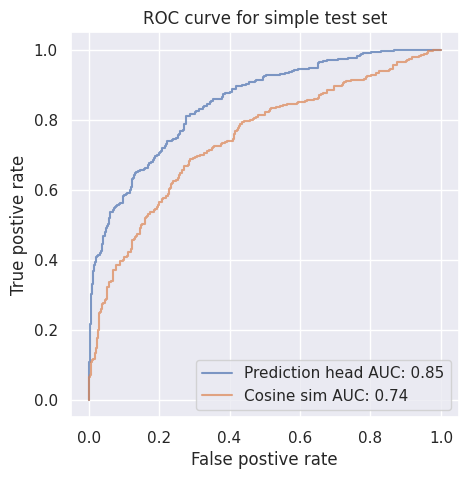

In [13]:
prefix = Path("data/ath_bol_aar/simple_sf_nsnf_500")
res_folder, results_file, val_path, _ = create_paths(prefix)
df = pd.read_csv(results_file, sep="\t", header=0, index_col=0)
preds, labels = run_best_model(df, val_path)
pred_cs, labels_cs = calc_cosine(val_path)

sns.set_theme(rc={'figure.figsize':(5,5)})
plot_auc(preds, labels, alpha=0.7, label=f"Prediction head")
plot_auc(pred_cs, labels_cs, alpha=0.7, label=f"Cosine sim")

plt.legend(loc="lower right")
plt.title("ROC curve for simple test set")
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.savefig(res_folder/"auc_val.png", dpi=300)
plt.show()

Best Params:
batch_size: 32, drop_out: 0.5, n_layers: 1, epoch: 453, AUC: 0.7554455937935151
Best Params:
batch_size: 64, drop_out: 0.5, n_layers: 1, epoch: 643, AUC: 0.7646012746774444


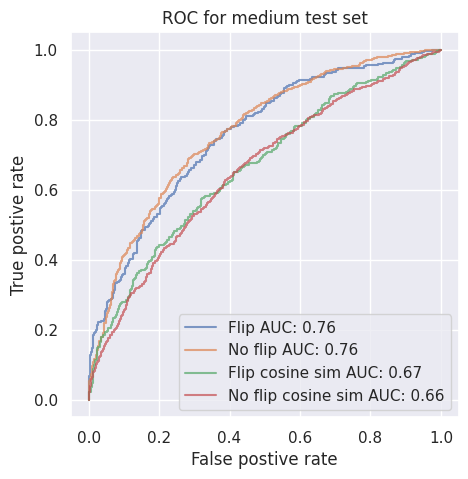

In [17]:
# Load everything
m_prefix = Path("data/aar_ath_bol_chi_cpa_tha/medium_2g_500")
res_folder_m, results_file, val_path, embeddings_path = create_paths(m_prefix)
m = pd.read_csv(results_file, sep="\t", header=0, index_col=0)
preds_m, labels_m = run_best_model(m, val_path, embeddings_path)
pred_cs_m, labels_cs_m = calc_cosine(val_path, embeddings_path)

m_prefix = Path("data/aar_ath_bol_chi_cpa_tha/medium_2g_500_noflip")
res_folder, results_file, val_path_nf, embeddings_path = create_paths(m_prefix)
m_nf = pd.read_csv(results_file, sep="\t", header=0, index_col=0)
preds_nf, labels_nf = run_best_model(m_nf, val_path_nf, embeddings_path)
pred_cs_nf, labels_cs_nf = calc_cosine(val_path_nf, embeddings_path)

sns.set_theme(rc={'figure.figsize':(5,5)})
plot_auc(preds_m, labels_m, alpha=0.7, label=f"Flip")
plot_auc(preds_nf, labels_nf,alpha=0.7, label=f"No flip")

plot_auc(pred_cs_m, labels_cs_m, alpha=0.7, label=f"Flip cosine sim")
plot_auc(pred_cs_nf, labels_cs_nf, alpha=0.7, label=f"No flip cosine sim")

plt.legend(loc="lower right")
plt.title("ROC for medium test set")
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.savefig(res_folder_m/"auc_val.png", dpi=300)
plt.show()

In [16]:
# Load everything
prefix = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000")
res_folder_m, results_file, val_path, embeddings_path = create_paths(prefix)
df = pd.read_csv(results_file, sep="\t", header=0, index_col=0)
preds_pca, labels_pca = run_best_model(df, val_path, embeddings_path)
pred_cs, labels_cs = calc_cosine(val_path, embeddings_path)

avg = Path(f"{prefix}_avg_embeddings.tsv")
preds_avg, labels_avg = run_best_model(df, val_path, avg)


Best Params:
batch_size: 32, drop_out: 0.5, n_layers: 1, epoch: 899, AUC: 0.5992887308290731
3840 -> 1024
Best Params:
batch_size: 32, drop_out: 0.5, n_layers: 1, epoch: 899, AUC: 0.5992887308290731
3840 -> 1024


In [17]:
div = Path(f"{prefix}_div3_embeddings.tsv.gz")
train_seq_path = Path(f"{prefix}_train.tsv")
test_seq_path = Path(f"{prefix}_test.tsv")


r = df.iloc[df['val_auc'].idxmax()]

train_loader = make_dataloaders(input_path=train_seq_path, 
                                embeddings=div, 
                                batch_size=int(r["batch_size"]))

test_loader = make_dataloaders(input_path=test_seq_path, 
                                embeddings=div, 
                                batch_size=int(r["batch_size"]))

model = modular_network(r["n_layers"], r["drop_out"], input_size=11520)

model, history, best_l, epoch = train_model(model, 1000, train_loader, test_loader, verbose=False, device=device)

val_loader = make_dataloaders(input_path=val_path, embeddings=div, batch_size=int(r['batch_size']))

model.eval()
preds, labels = run_validation(model, val_loader, device=device)

pred_cs, labels_cs = calc_cosine(val_path, div)


11520 -> 1024
Current epoch: 249
Early stopping!
Best loss: 0.7333249449729919, acc: 0.5390835579514824, epoch: 48


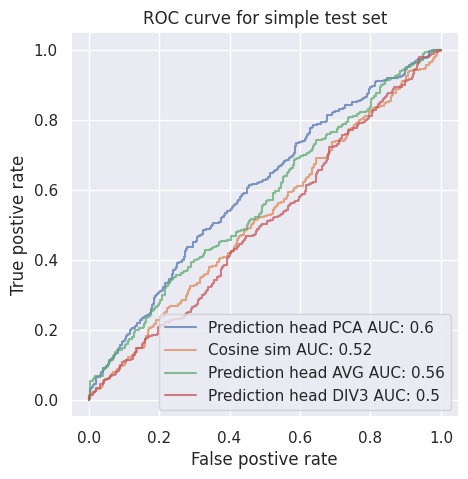

In [ ]:
sns.set_theme(rc={'figure.figsize':(5,5)})
plot_auc(preds_pca, labels_pca, alpha=0.7, label=f"Prediction head PCA")
plot_auc(pred_cs, labels_cs, alpha=0.7, label=f"Cosine sim")

plot_auc(preds_avg, labels_avg, alpha=0.7, label=f"Prediction head AVG")

plot_auc(preds, labels, alpha=0.7, label=f"Prediction head DIV3")

plt.legend(loc="lower right")
plt.title("ROC curve for I-ADHoRe dataset")
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.savefig(res_folder_m/"auc_val.png", dpi=300)
plt.show()